In [59]:
import torch
import torchaudio

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm


from soundbay.utils.checkpoint_utils import merge_with_checkpoint
from soundbay.models import EfficientNet2D
from soundbay.data import InferenceDataset

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# model_conf = Path('../soundbay/configs/models/efficientnet_2d.yaml')
model_conf = Path('../soundbay/configs/models/ResNet1Channel.yaml')
# \ResNet1Channel_spec_1000__4_sec

In [ ]:
model_args = merge_with_checkpoint({}, ckpt_args)

In [ ]:
model_checkpoint = Path('/mnt/d/DeepVoice/checkpoints/EfficientNet2D_spec_256__4_sec/best.pth')

model = EfficientNet2D(num_classes=3, pretrained=False, hidden_dim=68)
model.load_state_dict(torch.load(model_checkpoint, map_location=torch.device(device), weights_only=False)['model'])
model.to(device)
model.eval()

# ckpt_dict = torch.load(model_checkpoint, map_location=torch.device('cpu'), weights_only=False)
# ckpt_args = ckpt_dict['args']
# args = merge_with_checkpoint({}, ckpt_args)#args, ckpt_args)
# ckpt = ckpt_dict['model']

# model_name = 
# ckpt

EfficientNet2D(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

# proba inference
load file and create windowing function for prediction

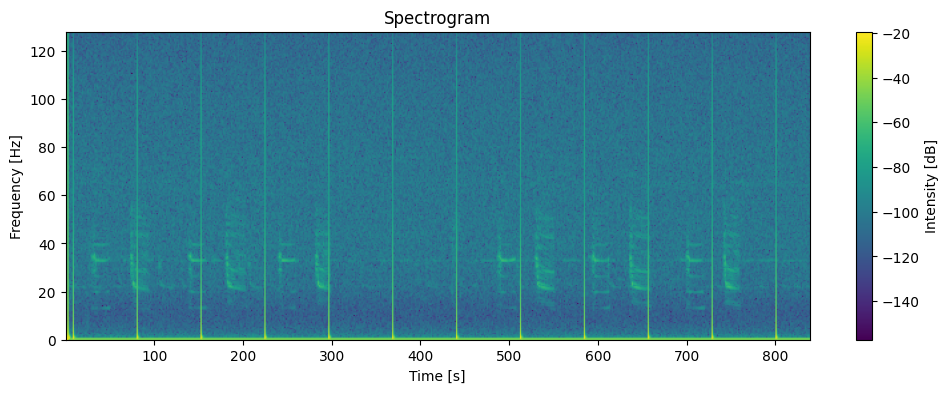

In [32]:
wav_file = Path("/mnt/d/DeepVoice/soundbay/datasets/temp_delete/5756.220318063455.wav")
waveform, sample_rate = torchaudio.load(wav_file)
# resample to 256 Hz
resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=256)
waveform = resample_transform(waveform)

# plot spectrogram
waveform_np = waveform.numpy()[0]
plt.figure(figsize=(12, 4))
plt.specgram(waveform_np, NFFT=512, Fs=256, noverlap=256//2, cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [ ]:
dataset_args = dict(dataset_args)
dataset_type = dataset_args.pop('_target_')
test_dataset = datasets_dict[dataset_type](**dataset_args)

dataset = InferenceDataset(wav_file, preprocessors=..., data_sample_rate=256, overlap=0.2)

test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=0,
                                 pin_memory=False)





In [49]:
def sliding_window_wav(model, sr, waveform, window_size_sec=4, step_size_sec=1):
    model.eval()
    window_size = window_size_sec * sr
    step_size = step_size_sec * sr
    num_windows = (waveform.shape[1] - window_size) // step_size + 1

    predictions = []
    with torch.no_grad():
        for i in tqdm(range(num_windows)):
            start = i * step_size
            end = start + window_size
            window = waveform[:, start:end].to(device)
            window = window.unsqueeze(0)  # add batch dimension
            output = model(window)
            proba = torch.softmax(output, dim=1)
            # proba = output
            predictions.append(proba.cpu().numpy())

    return np.vstack(predictions)

predictions = sliding_window_wav(model, 256, waveform, window_size_sec=4, step_size_sec=1)


100%|██████████| 837/837 [00:18<00:00, 45.37it/s]


In [51]:
predictions

array([[0.82872015, 0.09953295, 0.07174689],
       [0.82801723, 0.0984805 , 0.07350221],
       [0.82771903, 0.09787477, 0.07440621],
       ...,
       [0.82942736, 0.09661576, 0.07395691],
       [0.82942575, 0.09661884, 0.07395544],
       [0.82942986, 0.09661528, 0.07395494]], dtype=float32)

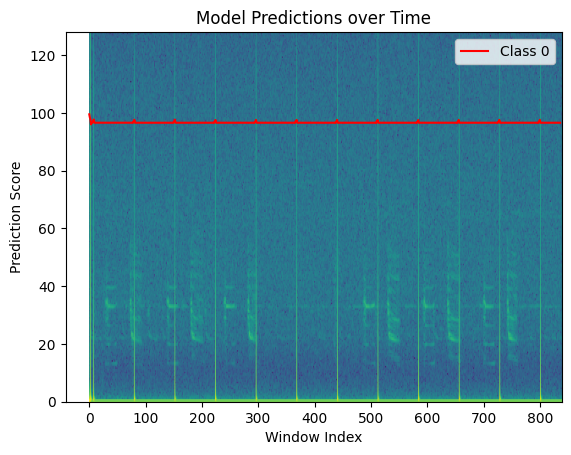

In [58]:
plt.specgram(waveform_np, NFFT=512, Fs=256, noverlap=256//2, cmap='viridis')
plt.plot(predictions[:, 1] * 1000, c = 'r')
plt.title('Model Predictions over Time')
plt.xlabel('Window Index')
plt.ylabel('Prediction Score')
plt.legend([f'Class {i}' for i in range(predictions.shape[1])])
plt.show()

In [43]:
def sliding_window_spectrogram(model, sr, waveform, n_fft=512, hop_length=256, window_size_seconds=4, hop_seconds=1, device='cpu'):
    model.to(device)
    model.eval()
    
    # waveform = waveform.to(device)

    # calculate spectrogram:
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(waveform)
    
    spec = spec.unsqueeze(0)  # add batch dimension
    predictions = []
    # spec shape: [batch=1, channel, freq, time]
    _, ch, freq, time_frames = spec.shape

    # frames per window and hop in spectrogram frames
    frames_per_window = max(1, int(round(window_size_seconds * sr / hop_length)))
    hop_frames = max(1, int(round(hop_seconds * sr / hop_length)))

    with torch.no_grad():
        # iterate windows
        for start in range(0, max(1, time_frames - frames_per_window + 1), hop_frames):
            win = spec[..., start:start + frames_per_window]  # [1, C, F, T_w]
            win = win.to(device)
            out = model(win)
            print(out.cpu().numpy())
            if isinstance(out, tuple):  # handle models that return (logits, aux)
                out = out[0]
            predictions.append(out.cpu().numpy())

        # if last window not aligned, include final window anchored at the end
        if time_frames > 0 and (time_frames - frames_per_window) % hop_frames != 0:
            start = max(0, time_frames - frames_per_window)
            win = spec[..., start:start + frames_per_window].to(device)
            out = model(win)
            print(out.cpu().numpy())
            if isinstance(out, tuple):
                out = out[0]
            predictions.append(out.cpu().numpy())

    if len(predictions) == 0:
        return np.empty((0, 0))
    return np.concatenate(predictions, axis=0)

predictions = sliding_window_spectrogram(model, 256, waveform, n_fft=512, hop_length=256, window_size_seconds=4, hop_seconds=1, device=device)

[[ -4.2068787  13.842059  -12.086286 ]]
[[ 0.5754094  -0.46021056  0.6245714 ]]
[[ 0.05269515 -0.26925677  0.7561825 ]]
[[ 0.308556    0.17980848 -0.35661486]]
[[ 1.0646186   0.30949154 -1.4807413 ]]
[[ 2.3544486  -0.40921968 -1.1563399 ]]
[[ 1.872766   -0.35792175 -0.5210394 ]]
[[ 1.4409416  -0.03273069 -1.1608627 ]]
[[ 1.0002786   0.29850748 -1.4393501 ]]
[[ 1.6748435  -0.05688166 -1.3457694 ]]
[[ 2.5382688  -0.46680668 -1.3813367 ]]
[[ 2.4786575  -0.44470343 -1.2871015 ]]
[[ 2.4815292  -0.44572195 -1.2907891 ]]
[[ 2.4778538  -0.44429052 -1.2869513 ]]
[[ 2.475577   -0.44327864 -1.284924  ]]
[[ 2.4604623  -0.43692797 -1.2705123 ]]
[[ 2.4742892  -0.44267502 -1.2838762 ]]
[[ 2.4643784 -0.4386173 -1.2741601]]
[[ 2.4590669  -0.43632126 -1.2692299 ]]
[[ 2.4471004 -0.4312718 -1.2578156]]
[[ 2.4564567  -0.43510062 -1.2670636 ]]
[[ 2.4605458 -0.4369043 -1.2707274]]
[[ 2.4499438  -0.43251088 -1.2604399 ]]
[[ 2.4436612  -0.42974418 -1.254813  ]]
[[ 2.4512055  -0.43295282 -1.2618902 ]]
[[ 2.4444

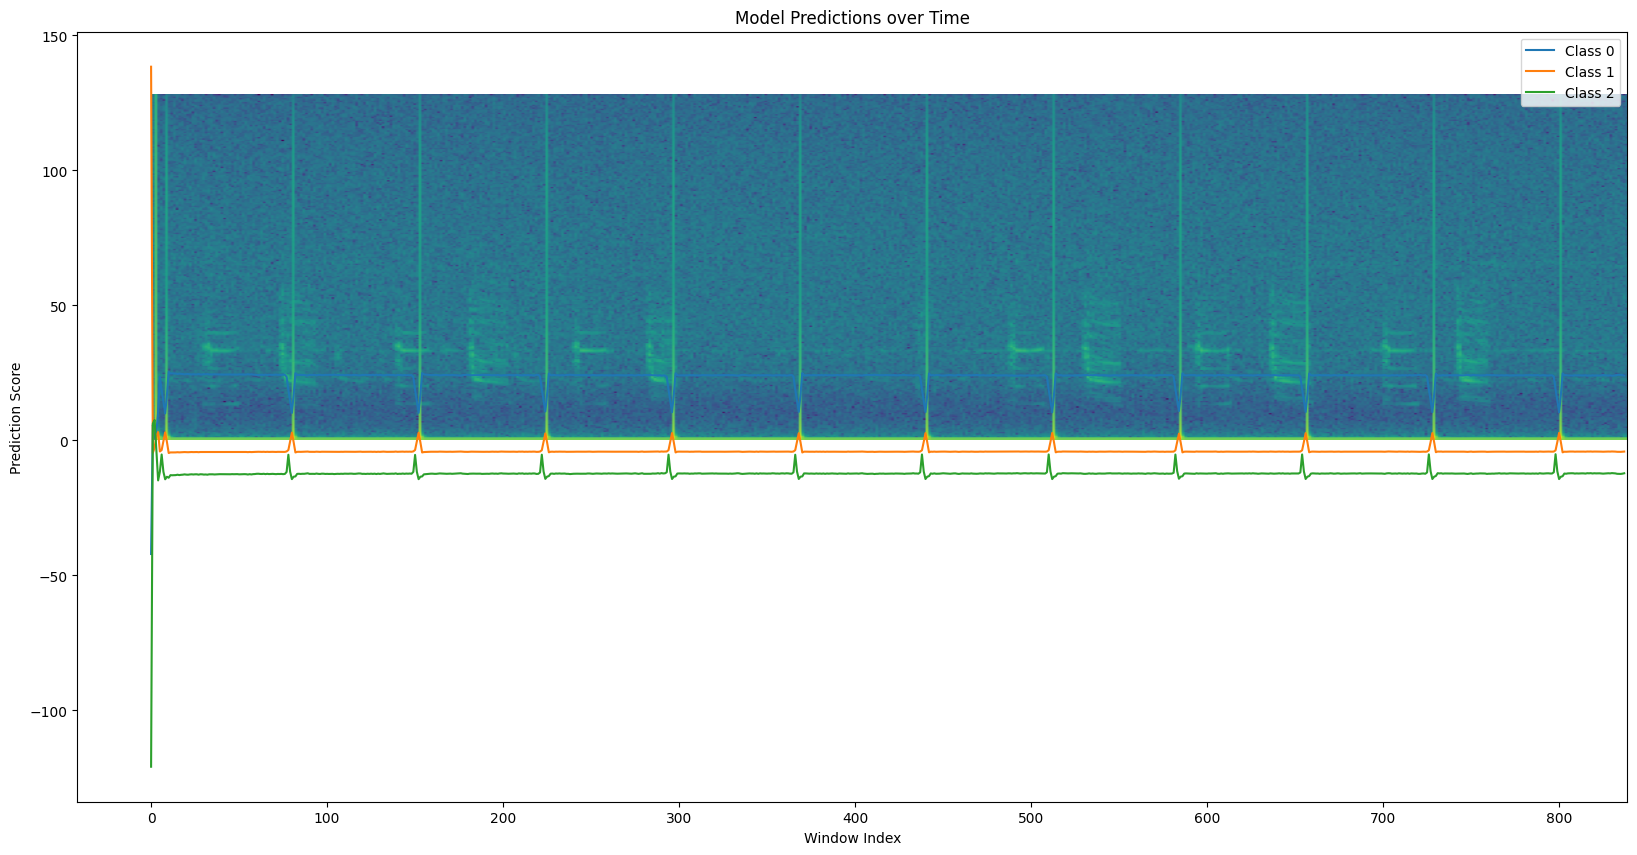

In [39]:
plt.figure(figsize=(20, 10))
plt.specgram(waveform_np, NFFT=512, Fs=256, noverlap=256//2, cmap='viridis')
plt.plot(predictions * 10)
plt.title('Model Predictions over Time')
plt.xlabel('Window Index')
plt.ylabel('Prediction Score')
plt.legend([f'Class {i}' for i in range(predictions.shape[1])])
plt.show()